In [2]:
import Pkg; Pkg.activate(@__DIR__); Pkg.add("PyPlot"); Pkg.add("ForwardDiff"); Pkg.instantiate()

  Activating project at `/workspaces/lecture-notebooks/Lecture 5`
   Resolving package versions...
  No Changes to `/workspaces/lecture-notebooks/Lecture 5/Project.toml`
  No Changes to `/workspaces/lecture-notebooks/Lecture 5/Manifest.toml`
   Resolving package versions...
  No Changes to `/workspaces/lecture-notebooks/Lecture 5/Project.toml`
  No Changes to `/workspaces/lecture-notebooks/Lecture 5/Manifest.toml`


In [3]:
using LinearAlgebra
using ForwardDiff
using PyPlot

In [4]:
Q = Diagonal([0.5; 1])
function f(x)
    return 0.5*(x-[1; 0])'*Q*(x-[1; 0])
end
function ∇f(x)
    return Q*(x-[1; 0])
end
function ∇2f(x)
    return Q
end

∇2f (generic function with 1 method)

In [5]:
A = [-1.0 1.0]
b = 1.0
function c(x)
    return dot(A,x) - b
end
function ∂c(x)
    return A
end

∂c (generic function with 1 method)

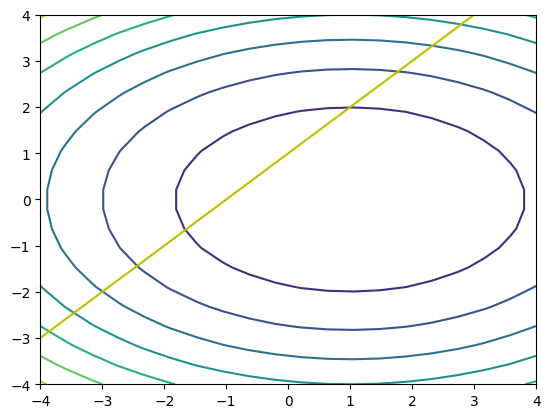

In [6]:
function plot_landscape()
    Nsamp = 20
    Xsamp = kron(ones(Nsamp),LinRange(-4,4,Nsamp)')
    Ysamp = kron(ones(Nsamp)',LinRange(-4,4,Nsamp))
    Zsamp = zeros(Nsamp,Nsamp)
    for j = 1:Nsamp
        for k = 1:Nsamp
            Zsamp[j,k] = f([Xsamp[j,k]; Ysamp[j,k]])
        end
    end
    contour(Xsamp,Ysamp,Zsamp)

    xc = LinRange(-4,3,Nsamp)
    plot(xc,xc.+1,"y")
end

plot_landscape()
display(gcf())

In [7]:
function ip_residual(z, ρ)
    x = z[1:2]
    σ = z[3]
    r = [∇f(x) - ∂c(x)'*sqrt(ρ)*exp(-σ);
         c(x) - sqrt(ρ)exp(σ)]
end

ip_residual (generic function with 1 method)

In [8]:
function kkt_residual(z)
    x = z[1:2]
    σ = z[3]
    λ = sqrt(ρ)*exp(-σ)

    r = [∇f(x) - ∂c(x)'*λ;
         min(λ, 0)
         min(c(x),0)
         λ*c(x)]
end

kkt_residual (generic function with 1 method)

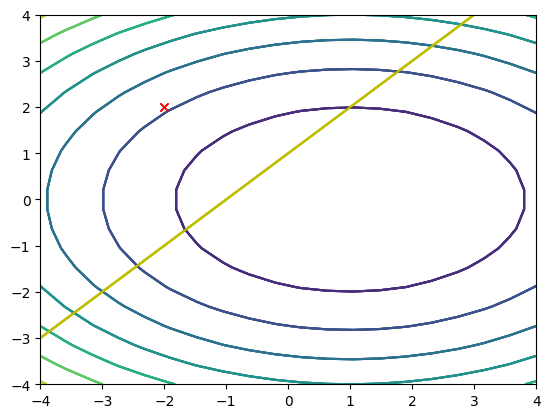

In [11]:
xguess = [-2; 2]
σguess = 0.0
z = [xguess; σguess]
plot_landscape()
plot(z[1], z[2], "rx")
display(gcf())

In [12]:
ρ = 1.0
ip_residual(z,ρ)

3×1 Matrix{Float64}:
 -0.5
  1.0
  2.0

In [13]:
kkt_residual(z)

5×1 Matrix{Float64}:
 -0.5
  1.0
  0.0
  0.0
  3.0

In [14]:
function newton_solve(z0,ρ,tol)

    #initial guess
    z = z0
    
    #KKT residual
    r = ip_residual(z,ρ)

    while norm(r) > tol       
        #H = ∇2f(x)
        #C = ∂c(x)

        #M = [H sqrt(ρ)*C'*exp(-σ);
        #    C -sqrt(ρ)*exp(σ)]

        #Newton step
        M = ForwardDiff.jacobian(dz->ip_residual(dz,ρ), z)
        Δz = -M\r

        znew = z + Δz
        rnew = ip_residual(znew,ρ)

        #Line search
        b = 0.1
        c = 0.5
        α = 1.0
        while norm(rnew) > (norm(r) + b*α*dot(r,M*Δz)/norm(r))
            α = c*α
            znew = z + α*Δz
            rnew = ip_residual(znew,ρ)
        end

        z = znew
        r = rnew
    end

    return z
end

newton_solve (generic function with 1 method)

In [15]:
z_iter = z

3-element Vector{Float64}:
 -2.0
  2.0
  0.0

In [35]:
ρ = 1.0e-8 #adjust from ρ=1 to ρ=1e-8 to observe convergence along central path
z = newton_solve(z_iter[:,end],ρ,1e-10)
z_iter = [z_iter z]

3×6 Matrix{Float64}:
 -2.0  -1.0  -0.426784  -0.334333  -0.333334  -0.333333
  2.0   1.0   0.713392   0.667166   0.666667   0.666667
  0.0   0.0  -0.813568  -3.04916   -6.50229   -8.80488

In [36]:
kkt_residual(z)

5×1 Matrix{Float64}:
  3.2596148002994596e-13
 -3.260725023324085e-13
  0.0
  0.0
  1.000000001423018e-8

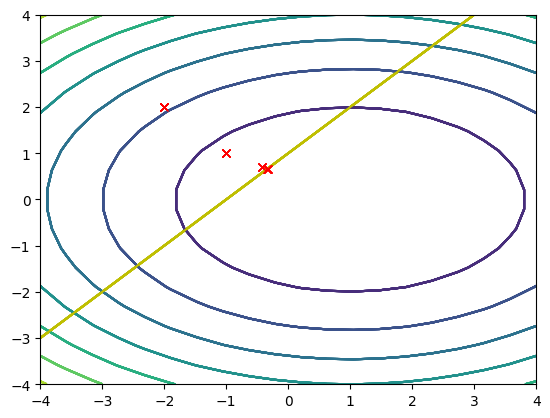

In [37]:
plot_landscape()
plot(z_iter[1,:], z_iter[2,:], "rx")
display(gcf())

In [38]:
M = ForwardDiff.jacobian(dz->ip_residual(dz,ρ), z)

3×3 Matrix{Float64}:
  0.5  0.0  -0.666667
  0.0  1.0   0.666667
 -1.0  1.0  -1.5e-8

In [39]:
eigvals(M)

3-element Vector{Float64}:
 -0.8526850467838316
  0.7169780264778028
  1.6357070053060303